## Introduction
This notebook is designed to implement a converter from images to LaTeX code.

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm # progress bar for notebooks
from PIL import Image, ImageOps
import random
import seaborn as sns

### Dataset Exploration

In [2]:
def show_image_from_path(img_path):
    """
    Displays an image given its file path.
    """
    with Image.open(img_path) as img:
        plt.figure(figsize=(8, 4))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"Image: {os.path.basename(img_path)}", fontsize=12)
        plt.show()

In [8]:
DATA_DIR = "../archive"
IMAGE_DIR = os.path.join(DATA_DIR, "formula_images_processed/formula_images_processed")
TRAIN_SPLIT_FILE = os.path.join(DATA_DIR, 'im2latex_train.csv')
VALID_SPLIT_FILE = os.path.join(DATA_DIR, 'im2latex_validate.csv')
TEST_SPLIT_FILE = os.path.join(DATA_DIR, 'im2latex_test.csv')
FORMULAS_FILE = os.path.join(DATA_DIR, 'im2latex_formulas.norm.csv')

In [4]:
def load_dataset_split_csv(filepath):
    df = pd.read_csv(filepath)

    # Build the list of tuples (image_path, formula)
    data = []
    for index, row in tqdm(df.iterrows(), total=len(df), desc=f"Loading {os.path.basename(filepath)}"):
        img_name = row['image']
        formula = str(row['formula'])
        img_path = os.path.join(IMAGE_DIR, img_name)
        data.append((img_path, formula))
    return data

print("Loading training dataset...")
train_data = load_dataset_split_csv(TRAIN_SPLIT_FILE)
print(f"Number of training samples: {len(train_data)}")

print("\nLoading validation dataset...")
valid_data = load_dataset_split_csv(VALID_SPLIT_FILE)
print(f"Number of validation samples: {len(valid_data)}")

print("\nLoading test dataset...")
test_data = load_dataset_split_csv(TEST_SPLIT_FILE)
print(f"Number of test samples: {len(test_data)}")

Loading training dataset...


Loading im2latex_train.csv:   0%|          | 0/75275 [00:00<?, ?it/s]

Number of training samples: 75275

Loading validation dataset...


Loading im2latex_validate.csv:   0%|          | 0/8370 [00:00<?, ?it/s]

Number of validation samples: 8370

Loading test dataset...


Loading im2latex_test.csv:   0%|          | 0/10355 [00:00<?, ?it/s]

Number of test samples: 10355


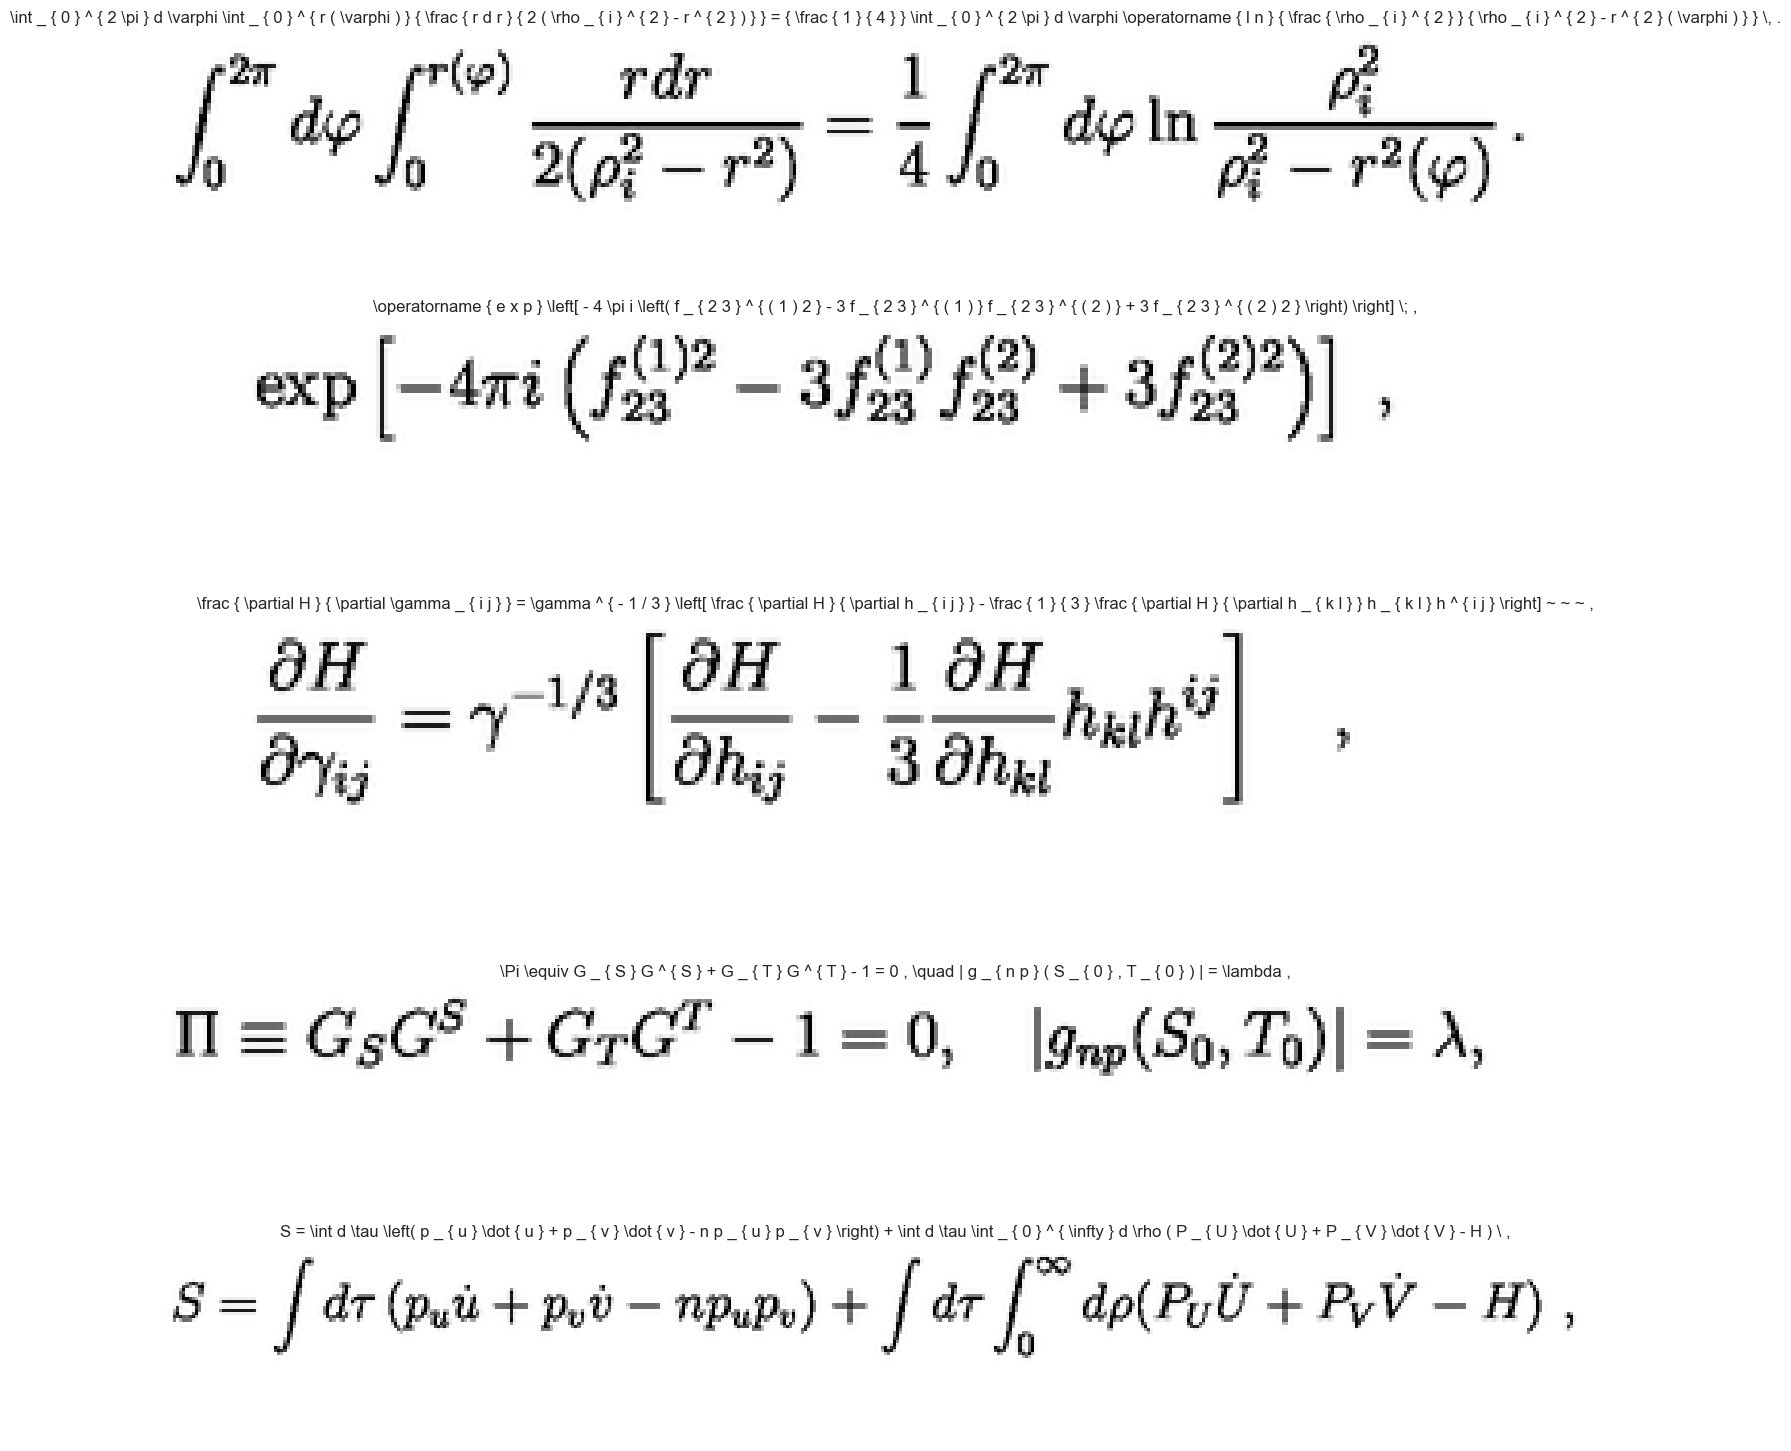

In [5]:
def show_image_formula_pairs(data, n=5):
    """Show n random image-formula pairs from the dataset"""
    samples = random.sample(data, n)

    plt.figure(figsize=(15, 3 * n))
    for i, (img_path, formula) in enumerate(samples):
        img = Image.open(img_path)

        plt.subplot(n, 1, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(formula, fontsize=12)

    plt.tight_layout()
    plt.show()

show_image_formula_pairs(train_data, n=5)

Analyzing image sizes...
Number of images analyzed: 5000
Min size: 128x32
Max size: 480x160
Average size: 283x52
Median size: 256x64


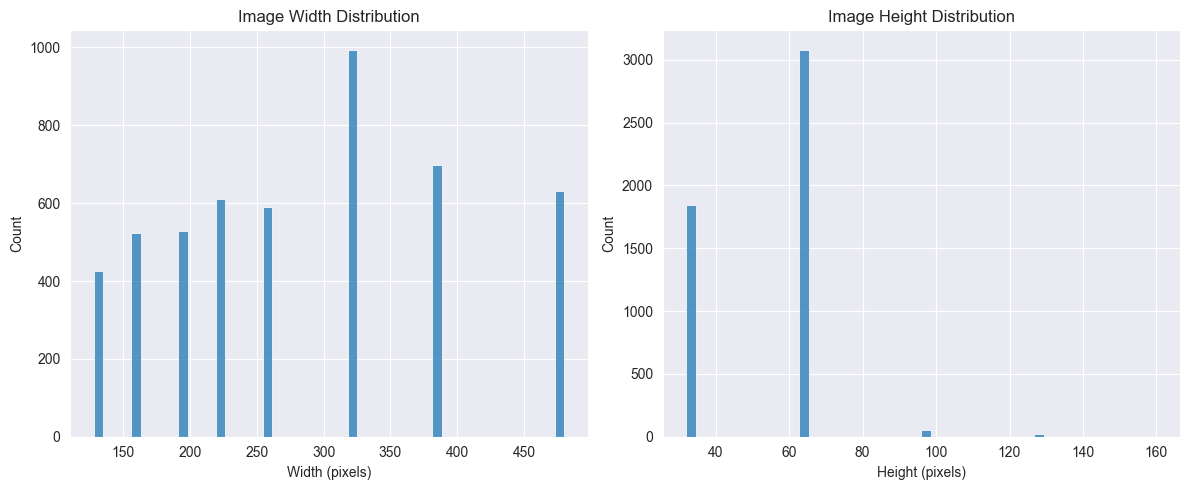

In [6]:
# Collect width and height of a sample of images
def get_image_sizes(data, sample_size=1000):
    """Return a list of (width, height) for a sample of images."""
    samples = random.sample(data, min(sample_size, len(data)))
    sizes = []
    for img_path, _ in samples:
        with Image.open(img_path) as img:
            sizes.append(img.size)  # (width, height)
    return sizes

print("Analyzing image sizes...")
image_sizes = get_image_sizes(train_data, sample_size=5000)
widths, heights = zip(*image_sizes)

# Basic statistics
print(f"Number of images analyzed: {len(image_sizes)}")
print(f"Min size: {min(widths)}x{min(heights)}")
print(f"Max size: {max(widths)}x{max(heights)}")
print(f"Average size: {sum(widths)//len(widths)}x{sum(heights)//len(heights)}")
print(f"Median size: {int(np.median(widths))}x{int(np.median(heights))}")

# Plot distribution of widths and heights
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(widths, bins=50)
plt.title("Image Width Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.histplot(heights, bins=50)
plt.title("Image Height Distribution")
plt.xlabel("Height (pixels)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [7]:
def get_max_image_size(datasets):
    """
    Returns the maximum and minimum width/height across all datasets,
    and prints the paths of the images with max and min width.
    """
    max_width, max_height = 0, 0
    min_width = float('inf')
    min_height = float('inf')

    max_width_path = ""
    min_width_path = ""

    for dataset in datasets:
        for img_path, _ in tqdm(dataset, desc="Scanning image sizes"):
            with Image.open(img_path) as img:
                width, height = img.size

                if width > max_width:
                    max_width = width
                    max_width_path = img_path

                if width < min_width:
                    min_width = width
                    min_width_path = img_path

                if height > max_height:
                    max_height = height
                    max_height_path = img_path

                if height < min_height:
                    min_height = height
                    min_height_path = img_path

    print(f"\nWidest image: {max_width} px → {max_width_path}")
    print(f"Narrowest image: {min_width} px → {min_width_path}")
    print(f"Tallest image: {max_height} px → {max_height_path}")
    print(f"Shortest image: {min_height} px → {min_height_path}")

    return max_width, min_width

In [8]:
max_w, max_h = get_max_image_size([train_data, valid_data, test_data])
print(f"Max image size (rounded): {max_w}x{max_h}")

Scanning image sizes:   0%|          | 0/75275 [00:00<?, ?it/s]

Scanning image sizes:   0%|          | 0/8370 [00:00<?, ?it/s]

Scanning image sizes:   0%|          | 0/10355 [00:00<?, ?it/s]


Widest image: 800 px → ./archive/formula_images_processed/formula_images_processed/399e18a85c.png
Narrowest image: 128 px → ./archive/formula_images_processed/formula_images_processed/e265f9dc6b.png
Tallest image: 800 px → ./archive/formula_images_processed/formula_images_processed/44b0400a8a.png
Shortest image: 32 px → ./archive/formula_images_processed/formula_images_processed/1cbb05a562.png
Max image size (rounded): 800x128


In [48]:
def find_tall_images(datasets, height_threshold=320, max_display=20):
    """
    Finds and reports images with height greater than a given threshold.

    Args:
        datasets (list of datasets): list of (img_path, formula) pairs.
        height_threshold (int): height in pixels to consider as 'too tall'.
        max_display (int): number of image paths to print.

    Returns:
        List of (img_path, height) for images above the threshold.
    """
    tall_images = []

    for dataset in datasets:
        for img_path, _ in dataset:
            with Image.open(img_path) as img:
                width, height = img.size
                if height > height_threshold:
                    tall_images.append((img_path, height))

    print(f"\nFound {len(tall_images)} images taller than {height_threshold}px.")

    if tall_images:
        print(f"Showing up to {max_display} example paths:")
        for img_path, h in tall_images[:max_display]:
            print(f"{h}px → {img_path}")

    return tall_images


In [49]:
# Cerca immagini con altezza > 320
tall_images = find_tall_images([train_data, valid_data, test_data], height_threshold=161)

print(f"\nTotal tall images found: {len(tall_images)}")


Found 12367 images taller than 401px.
Showing up to 20 example paths:
480px → ./archive/formula_images_processed/formula_images_processed/a4d25113b2.png
480px → ./archive/formula_images_processed/formula_images_processed/3cf9d0b234.png
480px → ./archive/formula_images_processed/formula_images_processed/5d1a1ed037.png
480px → ./archive/formula_images_processed/formula_images_processed/6fefdec123.png
480px → ./archive/formula_images_processed/formula_images_processed/9016b4fca0.png
480px → ./archive/formula_images_processed/formula_images_processed/2cb87ed9c8.png
480px → ./archive/formula_images_processed/formula_images_processed/4c6c104eb5.png
480px → ./archive/formula_images_processed/formula_images_processed/427968501c.png
480px → ./archive/formula_images_processed/formula_images_processed/65d334ea47.png
480px → ./archive/formula_images_processed/formula_images_processed/2b8e14887f.png
480px → ./archive/formula_images_processed/formula_images_processed/1ba2cffb3c.png
480px → ./archiv

### Padding and saving of cleaned images

In [54]:
def pad_image_to_size(img, target_size, background_color=(255, 255, 255)):
    """
    Pads an image to the target (width, height) with symmetric padding.
    The image is centered, and the background is white.
    """
    target_width, target_height = target_size
    img = img.convert("RGB")  # Ensure consistent mode

    width, height = img.size

    if width > target_width or height > target_height:
        raise ValueError(f"Image size {width}x{height} exceeds target {target_width}x{target_height}.")

    delta_width = target_width - width
    delta_height = target_height - height

    pad_left = delta_width // 2
    pad_right = delta_width - pad_left
    pad_top = delta_height // 2
    pad_bottom = delta_height - pad_top

    padding = (pad_left, pad_top, pad_right, pad_bottom)
    return ImageOps.expand(img, padding, fill=background_color)

In [52]:
import os
from tqdm import tqdm

def save_clean_padded_dataset(data, output_dir, target_size, excluded_paths=None):
    """
    Saves all images in `data` to `output_dir`, padded to `target_size`.
    Excludes images in `excluded_paths`.

    Args:
        data (list): list of (img_path, formula)
        output_dir (str): where to save new images
        target_size (tuple): (width, height)
        excluded_paths (set): paths to skip
    """
    os.makedirs(output_dir, exist_ok=True)
    excluded_paths = excluded_paths or set()

    for img_path, _ in tqdm(data, desc=f"Saving padded images to {output_dir}"):
        if img_path in excluded_paths:
            continue

        try:
            with Image.open(img_path) as img:
                padded_img = pad_image_to_size(img, target_size)
                filename = os.path.basename(img_path)
                name, ext = os.path.splitext(filename)
                new_filename = f"{name}_resized{ext}"
                save_path = os.path.join(output_dir, new_filename)
                padded_img.save(save_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")


In [56]:
# Define target size (width x height)
TARGET_SIZE = (800, 160)

# Convert tall_images (list of tuples) to a set of paths
excluded_train_paths = set(p for p, h in tall_images)

# Save datasets
save_clean_padded_dataset(train_data, "../clean_padded/train", TARGET_SIZE)
save_clean_padded_dataset(valid_data, "../clean_padded/val", TARGET_SIZE)
save_clean_padded_dataset(test_data, "../clean_padded/test", TARGET_SIZE, excluded_paths=excluded_train_paths)

Saving padded images to ./clean_padded/test: 100%|██████████| 10355/10355 [00:14<00:00, 714.59it/s]


### Building the vocabulary for tokens in the LaTeX formulas

In [14]:
import pandas as pd
from collections import Counter
import pickle

In [15]:
# Special token IDs
START_TOKEN = 0  # <sos>
PAD_TOKEN = 1    # <pad>
END_TOKEN = 2    # <eos>
UNK_TOKEN = 3    # <unk>

special_tokens = {
    "<s>": START_TOKEN,
    "<pad>": PAD_TOKEN,
    "</s>": END_TOKEN,
    "<unk>": UNK_TOKEN
}

In [16]:
class Vocab:
    def __init__(self, min_freq=1):
        self.sign2id = special_tokens.copy()
        self.id2sign = {idx: token for token, idx in self.sign2id.items()}
        self.length = len(self.sign2id)
        self.min_freq = min_freq

    def build(self, formulas):
        counter = Counter()
        for formula in formulas:
            tokens = formula.split()
            counter.update(tokens)

        for token, freq in counter.items():
            if freq >= self.min_freq and token not in self.sign2id:
                self.sign2id[token] = self.length
                self.id2sign[self.length] = token
                self.length += 1

    def __len__(self):
        return self.length

    def save(self, path):
        with open(path, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(path):
        with open(path, "rb") as f:
            return pickle.load(f)

In [17]:
import os

dataset_names = ["train", "validate", "test"]

all_formulas = []
for name in dataset_names:
    csv_path = os.path.join(DATA_DIR, f"im2latex_{name}.csv")
    df = pd.read_csv(csv_path)
    formulas = df["formula"].astype(str).tolist()
    all_formulas.extend(formulas)

# Create the vocabulary
vocab = Vocab(min_freq=2)
vocab.build(all_formulas)
print(f"Vocab built with {len(vocab)} tokens.")

# Save the vocabulary
vocab.save("vocab.pkl")


Vocab built with 519 tokens.


In [18]:
# usage example
vocab = Vocab.load("../vocab.pkl")
print(vocab.sign2id["\\frac"])
print(vocab.id2sign[20])

20
\frac


In [19]:
def formula_to_ids(formula, vocab):
    tokens = formula.split()
    ids = [vocab.sign2id.get(token, UNK_TOKEN) for token in tokens]
    return [START_TOKEN] + ids + [END_TOKEN]

In [20]:
formula_to_ids("\widetilde \gamma _ { \mathrm { h o p f } } \simeq \sum _ { n > 0 } \widetilde { G } _ { n } { \frac { ( - a ) ^ { n } } { 2 ^ { 2 n - 1 } } }", vocab)

[0,
 4,
 5,
 6,
 7,
 8,
 7,
 9,
 10,
 11,
 12,
 13,
 13,
 14,
 15,
 6,
 7,
 16,
 17,
 18,
 13,
 4,
 7,
 19,
 13,
 6,
 7,
 16,
 13,
 7,
 3,
 7,
 21,
 22,
 23,
 24,
 25,
 7,
 16,
 13,
 13,
 7,
 26,
 25,
 7,
 26,
 16,
 22,
 27,
 13,
 13,
 13,
 2]

### Model

In [21]:
import torch
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using device: {device}")
else:
    device = torch.device("cpu")
    print("MPS not available, falling back to CPU.")

True
True
Using device: mps


In [22]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import torch
import torch.nn as nn
import torchvision.models as models

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [24]:
class ImageToLatexDataset(Dataset):
    def __init__(self, csv_file, images_dir, vocab, transform=None, max_len=150):
        import pandas as pd
        self.data = pd.read_csv(csv_file)
        self.images_dir = images_dir
        self.vocab = vocab
        self.transform = transform
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        formula = row['formula']
        image_path = os.path.join(self.images_dir, row['image'])

        # Load and transform image
        image = Image.open(image_path).convert('L')  # grayscale
        if self.transform:
            image = self.transform(image)

        # Tokenize formula
        tokens = formula.strip().split()
        token_ids = [self.vocab.sign2id['<s>']] + [self.vocab.sign2id.get(tok, self.vocab.sign2id['<unk>']) for tok in tokens] + [self.vocab.sign2id['</s>']]

        # Padding
        if len(token_ids) < self.max_len:
            token_ids += [self.vocab.sign2id['<pad>']] * (self.max_len - len(token_ids))
        else:
            token_ids = token_ids[:self.max_len]

        input_ids = torch.tensor(token_ids[:-1])  # input to decoder
        target_ids = torch.tensor(token_ids[1:])  # target output

        return image, input_ids, target_ids

In [25]:
# Define image transform
image_transform = transforms.Compose([
    transforms.Resize((160, 800)),  # Your original dimensions
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [26]:
csv_path = os.path.join(DATA_DIR, 'im2latex_train.csv')
df = pd.read_csv(csv_path)

# aggiunge _resized prima di .png in colonna 'image'
df['image'] = df['image'].apply(lambda x: x.replace('.png', '_resized.png'))

# salva su un nuovo csv (o sovrascrivi)
fixed_csv_path = os.path.join(DATA_DIR, 'im2latex_train_resized.csv')
df.to_csv(fixed_csv_path, index=False)

In [27]:
dataset = ImageToLatexDataset(csv_file=fixed_csv_path,
                              images_dir='../clean_padded/train',
                              vocab=vocab,
                              transform=image_transform)

dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=False)

In [28]:
class EncoderCNN(nn.Module):
    def __init__(self, output_dim=512):
        super(EncoderCNN, self).__init__()
        base_model = models.resnet18(pretrained=False)
        base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # from RGB to grayscale
        modules = list(base_model.children())[:-2]  # remove avgpool + fc
        self.cnn = nn.Sequential(*modules)
        self.output_conv = nn.Conv2d(512, output_dim, kernel_size=1)

    def forward(self, images):
        # images: (B, 1, 160, 800)
        features = self.cnn(images)  # (B, 512, H', W')
        features = self.output_conv(features)  # (B, output_dim, H', W')
        B, C, H, W = features.shape
        features = features.permute(0, 2, 3, 1)  # (B, H, W, C)
        features = features.reshape(B, H * W, C)  # (B, seq_len, C)
        return features  # encoder output sequence

In [29]:
class DecoderLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, encoder_dim=512, hidden_dim=512, num_layers=1):
        super(DecoderLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=1)
        self.lstm = nn.LSTM(embed_dim + encoder_dim, hidden_dim, num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, encoder_out, input_ids):
        """
        encoder_out: (B, seq_len_enc, encoder_dim)
        input_ids: (B, seq_len_dec)
        """
        B, seq_len_enc, encoder_dim = encoder_out.shape
        _, seq_len_dec = input_ids.shape

        embedded = self.embedding(input_ids)  # (B, seq_len_dec, embed_dim)

        # Media spaziale dei feature per ciascuna immagine
        context = encoder_out.mean(dim=1)  # (B, encoder_dim)
        context = context.unsqueeze(1).repeat(1, seq_len_dec, 1)  # (B, seq_len_dec, encoder_dim)

        lstm_input = torch.cat([embedded, context], dim=2)  # (B, seq_len_dec, embed+encoder_dim)
        outputs, _ = self.lstm(lstm_input)  # (B, seq_len_dec, hidden_dim)
        logits = self.fc_out(outputs)  # (B, seq_len_dec, vocab_size)
        return logits

In [30]:
class Im2LatexModel(nn.Module):
    def __init__(self, vocab_size):
        super(Im2LatexModel, self).__init__()
        self.encoder = EncoderCNN(output_dim=512)
        self.decoder = DecoderLSTM(vocab_size)

    def forward(self, images, input_ids):
        encoder_out = self.encoder(images)
        logits = self.decoder(encoder_out, input_ids)
        return logits  # (B, seq_len, vocab_size)

In [31]:
len(dataloader)

4705

In [32]:
model = Im2LatexModel(vocab_size=len(vocab)).to(device)

for batch in dataloader:
    images, input_ids, target_ids = batch
    images, input_ids, target_ids = images.to(device), input_ids.to(device), target_ids.to(device)
    logits = model(images, input_ids)  # (B, seq_len, vocab_size)
    break


/Users/tommaso/Desktop/miei file/ML/project/code/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tommaso/Desktop/miei file/ML/project/code/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [33]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [35]:
num_epochs = 5
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    # Wrap the dataloader with tqdm
    # You can also add a description to the progress bar for better clarity
    for images, input_ids, target_ids in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, input_ids, target_ids = images.to(device), input_ids.to(device), target_ids.to(device)

        optimizer.zero_grad()
        logits = model(images, input_ids)  # (B, seq_len, vocab_size)

        # CrossEntropyLoss expects (B * seq_len, vocab_size) and (B * seq_len)
        loss = criterion(logits.view(-1, logits.size(-1)), target_ids.view(-1))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss/len(dataloader):.4f}")

Epoch 1/5:   0%|          | 0/4705 [00:00<?, ?it/s]

KeyboardInterrupt: 